In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, PReLU
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy.stats as stats
import tensorflow as tf


# train data load
train_err = pd.read_csv('/content/drive/MyDrive/Colab/data/LG/train_err_data.csv')
train_quality = pd.read_csv('/content/drive/MyDrive/Colab/data/LG/train_quality_data.csv')
train_problem = pd.read_csv('/content/drive/MyDrive/Colab/data/LG/train_problem_data.csv')

# test data load
test_err = pd.read_csv('/content/drive/MyDrive/Colab/data/LG/test_err_data.csv')
test_quality = pd.read_csv('/content/drive/MyDrive/Colab/data/LG/test_quality_data.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
print(f'train_err의 고유 user_id는 {len(train_err.user_id.unique())}개 입니다')
print(f'train_quality의 고유 user_id는 {len(train_quality.user_id.unique())}개 입니다')
print(f'train_problem의 고유 user_id는 {len(train_problem.user_id.unique())}개 입니다')
print()
print(f'test_err의 고유 user_id는 {len(test_err.user_id.unique())}개 입니다')
print(f'test_quality의 고유 user_id는 {len(test_quality.user_id.unique())}개 입니다')

train_err의 고유 user_id는 15000개 입니다
train_quality의 고유 user_id는 8281개 입니다
train_problem의 고유 user_id는 5000개 입니다

test_err의 고유 user_id는 14998개 입니다
test_quality의 고유 user_id는 8268개 입니다


# train_err 파일

In [3]:
# train_err의 정보 확인
# train_err는 user_id, timie, model_nm, fwver, errtype, errcode 컬럼이 존재
# model_nm, fwver, errcode는 각각 object 형태
print(train_err.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16554663 entries, 0 to 16554662
Data columns (total 6 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   user_id   int64 
 1   time      int64 
 2   model_nm  object
 3   fwver     object
 4   errtype   int64 
 5   errcode   object
dtypes: int64(3), object(3)
memory usage: 757.8+ MB
None


In [4]:
# train_err의 결측치 확인
print(train_err.isnull().sum())

# 확인결과 결측치는 errcode 컬럼에서 단 한개
# 해당 행과 앞뒤 행까지 확인
null_index = train_err.index[train_err['errcode'].isna()][0]
display(train_err.iloc[null_index-1:null_index+2, :])

user_id     0
time        0
model_nm    0
fwver       0
errtype     0
errcode     1
dtype: int64


,user_id,time,model_nm,fwver,errtype,errcode
3825743,13639,20201121174110,model_2,04.33.1261,31,0
3825744,13639,20201121191718,model_2,04.33.1261,5,NaN
3825745,13639,20201121191718,model_2,04.33.1261,5,40013


In [5]:
# 16554663개 중에 1개 행렬이므로 해당 행 제거
# train_err = train_err.dropna()

# 혹은 바로 다음 행과 컬럼 배열이 동일하므로 40013으로 대체
train_err = train_err.fillna(40013)

In [6]:
# train_err의 각 컬럼간의 교차 분석
# user_id, time은 우선적으로 제외하고
# model_nm, fwver, errtype, errcode로 분석 진행
# 비식별 데이터지만 컬럼 이름으로 유추컨대
# model_nm - 모델 이름, fwver - 펌웨어 버전, errtype - 에러타입, errcode - 에러 코드라 추정해 볼 수 있음
                              # 펌웨어란 하드웨어의 제어(low-level control)와 구동을 담당하는 일종의 운영체제
# 추정이 맞다면 위 컬럼들은 범주형 변수에 해당

columns = ['model_nm','fwver','errtype','errcode']

for column in columns:
    print(f'{column}의 최빈값은 {train_err[column].mode()[0]}입니다.')

model_nm의 최빈값은 model_1입니다.
fwver의 최빈값은 04.16.3553입니다.
errtype의 최빈값은 23입니다.
errcode의 최빈값은 1입니다.


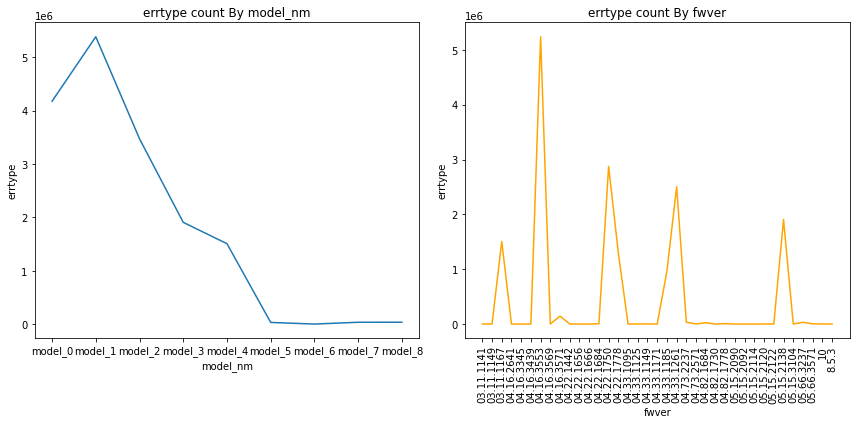

In [7]:
# 시각화
fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
ax1.plot(train_err.groupby(train_err['model_nm'])['errtype'].count())
ax1.title.set_text('errtype count By model_nm')
ax1.set_xlabel('model_nm')
ax1.set_ylabel('errtype')

ax2 = plt.subplot(122)
ax2.plot(train_err.groupby(train_err['fwver'])['errtype'].count(), color='orange')
ax2.title.set_text('errtype count By fwver')
ax2.set_xlabel('fwver')
ax2.set_ylabel('errtype')
plt.xticks(rotation=90)
fig.tight_layout()

plt.show()

# model_nm, fwver 각각의 최빈값인 model_1, 04.16.3553에서
# 가장 많은 수의 errtype count가 나왔고
# model_nm의 경우, model_1, model_0, model_2 순으로 errtype count가 높으며
# model_1일 때를 제외하고 model 넘버가 높아질수록 errtype count가 감소
# fwver의 경우, 04.16.3553, 03.11.1167 등을 비롯한 특정 fwver 5개에서
# 유독 높은 errtype count를 확인할 수 있음

In [8]:
#카이제곱검정을 통한 독립성 검정

# 교차표 생성 및 카이제곱검정
for first_column in columns:
    for second_column in columns:
        # 비교군이 같은 경우 continue
        if first_column == second_column:
            continue
        else:
            result = pd.crosstab(train_err[first_column], train_err[second_column])
            print(f'{first_column}과 {second_column}의 p-value는 {stats.chi2_contingency(observed=result)[1]}입니다')

model_nm과 fwver의 p-value는 0.0입니다
model_nm과 errtype의 p-value는 0.0입니다
model_nm과 errcode의 p-value는 0.0입니다
fwver과 model_nm의 p-value는 0.0입니다
fwver과 errtype의 p-value는 0.0입니다
fwver과 errcode의 p-value는 0.0입니다
errtype과 model_nm의 p-value는 0.0입니다
errtype과 fwver의 p-value는 0.0입니다
errtype과 errcode의 p-value는 0.0입니다
errcode과 model_nm의 p-value는 0.0입니다
errcode과 fwver의 p-value는 0.0입니다
errcode과 errtype의 p-value는 0.0입니다


In [ ]:
# 독립성 검정 결과로 나온
# 모든 두 컬럼들 사이의 p-value는 0.0으로 유의수준 0.05하에서 귀무가설 기각
# 따라서, 모든 두 컬럼들 사이에는 관련성이 존재

# train_quality 파일

In [9]:
# train_quality의 정보 확인
# train_err는 timie, user_id, fwver, quality_0 ~ quality_12 컬럼이 존재
# fwver, quality_5,7,8,9,10은 각각 object 형태
train_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828624 entries, 0 to 828623
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time        828624 non-null  int64  
 1   user_id     828624 non-null  int64  
 2   fwver       788544 non-null  object 
 3   quality_0   684192 non-null  float64
 4   quality_1   828624 non-null  int64  
 5   quality_2   788511 non-null  float64
 6   quality_3   828624 non-null  int64  
 7   quality_4   828624 non-null  int64  
 8   quality_5   828604 non-null  object 
 9   quality_6   828624 non-null  int64  
 10  quality_7   828624 non-null  object 
 11  quality_8   828624 non-null  object 
 12  quality_9   828624 non-null  object 
 13  quality_10  828624 non-null  object 
 14  quality_11  828624 non-null  int64  
 15  quality_12  828624 non-null  int64  
dtypes: float64(2), int64(8), object(6)
memory usage: 101.2+ MB


In [10]:
print(f'train_err의 고유 user_id는 {len(train_err.user_id.unique())}개 입니다')
print(f'train_quality의 고유 user_id는 {len(train_quality.user_id.unique())}개 입니다')
print(f'train_problem의 고유 user_id는 {len(train_problem.user_id.unique())}개 입니다')

train_err의 고유 user_id는 15000개 입니다
train_quality의 고유 user_id는 8281개 입니다
train_problem의 고유 user_id는 5000개 입니다


In [13]:
# train_problem에 한번이라도 나와 있는 유저는
# 시스템 풀질에 불편을 느꼈다고 할때

quality_user = train_quality.user_id.unique()
problem_user = train_problem.user_id.unique()
quality_problem_user = [x for x in quality_user if x in problem_user]
print(f'quality_user {len(quality_user)}명 중 불편을 느낀 user의 수는 {len(quality_problem_user)}명 입니다.')

# 따라서, quality_user 8281명 중 3167명은 불편을 느낌.

quality_user 8281명 중 불편을 느낀 user의 수는 3167명 입니다.


In [14]:
# object형태인 quality_5,7,8,9,10은
# 확인결과 숫자가 천단위로 넘어가면 ',' 가 붙기 때문.
# 특이한 점은 quality_8의 경우, 
# 같은 수라도 어떤 값은 int, 어떤 값은 str로 표현. ex) 0, '0'
# 또한, quality_3, quality_4는 모두 0으로 버려도 무방

# 데이콘 baseline의 함수를 커스터마이징 해 봤으나
# 컬럼 하나 돌리는데 시간이 꽤나 많이 드는듯,,,
def string2num(Series):
    # (,)( )과 같은 불필요한 데이터 정제
    for i in range(len(Series)):
        Series[i] = re.sub(r"[^0-9]+", '', str(Series[i]))
        if Series[i] == '':
            Series[i] = 0
        else:
            Series[i] = int(Series[i])
    return Series

In [15]:
# quality가 어떤 변수인지는 모르겠으나
# 일단 fwb가 범주형 변수이므로 카이제곱검정을 시행해 보았음.
# 이 결과, 0으로만 이뤄진 quality_3, quality_4를 제외하고
# quality_5는 fwv와 독립.

for i in range(13):
    quality = 'quality_' + str(i)
    result = pd.crosstab(train_quality.fwver, train_quality[quality])
    p_value = stats.chi2_contingency(observed=result)[1]
    print(f'p_value값은 {p_value}입니다.')

p_value값은 0.0입니다.
p_value값은 0.0입니다.
p_value값은 0.0입니다.
p_value값은 1.0입니다.
p_value값은 1.0입니다.
p_value값은 1.0입니다.
p_value값은 0.0입니다.
p_value값은 0.0입니다.
p_value값은 0.0입니다.
p_value값은 0.0입니다.
p_value값은 0.0입니다.
p_value값은 0.0입니다.
p_value값은 0.0입니다.


In [ ]:
# 향후, quality에서 전처리가 된다면
# fwb와의 카이제곱검정은 재진행이 필요
# 또한 quality간의 corr()를 통해
# 상관관계 분석도 해볼 수 있을 듯

# Modeling

In [127]:
# 데이콘 베이스라인 Modeling
# errtype counts를 변수로 problem에서 
# 한 번이라도 user_id가 나오면 오류가 발생했다고 설정

train_user_id_max = 24999
train_user_id_min = 10000
train_user_number = 15000

id_error = train_err[['user_id','errtype']].values
error = np.zeros((train_user_number,42))

for person_idx, err in tqdm(id_error):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    error[person_idx - train_user_id_min,err - 1] += 1
error.shape

# error와 동일한 방법으로 person_idx - 10000 위치에 
# person_idx의 problem이 한 번이라도 발생했다면 1
# 없다면 0
problem = np.zeros(15000)
problem[train_problem.user_id.unique()-10000] = 1 
problem.shape

X = error
Y = problem

 10%|█         | 1660746/16554663 [00:04<00:40, 369836.57it/s]


KeyboardInterrupt: ignored

In [ ]:
fwv = []
for i in range(train_user_id_min, train_user_id_max+1):
    fwv.append(train_err[train_err['user_id'] == i].fwver.mode()[0])

fwv = np.array(fwv)
fwv

In [ ]:
model = []
for i in range(train_user_id_min, train_user_id_max+1):
    model.append(train_err[train_err['user_id'] == i].model_nm.mode()[0])

model = np.array(model)
model

In [ ]:
fwv_series = pd.Series(fwv,name='fwv')
model_series = pd.Series(model,name='model')

In [ ]:
error_df = pd.DataFrame(error)

zscore = 1.8
for col in error_df.columns:
    outliers = error_df[col][np.abs(stats.zscore(error_df[col])) > zscore]
    col_mean = np.mean(error_df.loc[~error_df[col].isin(outliers), col])
    error_df.loc[error_df[col].isin(outliers), col] = col_mean

In [ ]:
# error_df = pd.concat([error_df,fwv_series], axis=1)
error_df = pd.concat([error_df,model_series], axis=1)
error_df.head()

In [ ]:
error_df = error_df.drop([7,8,18,20,29], axis=1)
error_df

In [ ]:
X = pd.get_dummies(error_df)
# X = X.values

In [128]:
X.shape

(15000, 46)

In [ ]:
train_err.groupby(train_err['errtype']).count()
# 89192130

In [ ]:
# Normalization
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

# from sklearn.preprocessing import RobustScaler
# scaler = RobustScaler()
# scaler.fit(X)
# X = scaler.transform(X)

# train_test_split
x_train, x_val, y_train, y_val = \
train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

In [ ]:
## NN

def build_nn():
    earlystop = EarlyStopping(patience=10)
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=2,
                                            factor=0.8,
                                            min_lr=1e-7,
                                            verbose=1)
    model_check = ModelCheckpoint( #에포크마다 현재 가중치를 저장    
            filepath="./lg_nn.h5", #모델 파일 경로
            monitor='val_loss',  # val_loss 가 좋아지지 않으면 모델 파일을 덮어쓰지 않음.
            save_best_only=True)

    callbacks = [earlystop, learning_rate_reduction, model_check]

    model = Sequential()
    model.add(Dense(7500, kernel_initializer='he_normal',
                    input_shape=(x_train.shape[1],)))  # input_shape로 input layer의 역할까지도 처리
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.7))

    model.add(Dense(3750, kernel_initializer='he_normal'))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.7))

    # model.add(Dense(750, kernel_initializer='he_normal'))
    # model.add(PReLU())
    # model.add(BatchNormalization())
    # model.add(Dropout(0.7))

    model.add(Dense(1, activation='sigmoid', kernel_initializer='he_normal'))

    model.compile(optimizer=Adam(learning_rate=0.0001),
                loss='binary_crossentropy',
                metrics=['binary_accuracy',AUC()])

    history = model.fit(x_train,
                        y_train,
                        epochs=100,
                        verbose=1,
                        validation_data=(x_val,y_val),
                        callbacks=callbacks)
    
    return history

In [ ]:
build_nn()